# Fawcett's formula

Consider the (Stratonovich) signature of standard Brownian motion $\mathbb{W}^{<\infty}_{0,T}$ (without time extension for simplicity). We claim that
$$
\mathbb{E} \left[ \mathbb{W}^{<\infty}_{0,T} \right] = \exp_{\otimes} \left( \frac{T}{2} \sum_{i=1}^d e_i \otimes e_i \right).
$$
In this notebook, we are going to verify the formula numerically based on simulations.

# Set up our environment

We will use the package `iisignature` to compute signatures.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import iisignature as ii

# Generate paths of the Brownian motion

Write a function to generate sample paths of the Brownian motion, and then generate a sample.

In [ ]:
def generate_Brownian_motion(M: int, N: int, d: int, T: float, rng: np.random.Generator) -> np.ndarray:
    """_summary_

    Parameters
    ----------
    M : int
        Number of paths to be generated.
    N : int
        Number of timesteps. We use a uniform grid.
    d : int
        Dimension of the Brownian motion.
    T : float
        Endpoint of the interval.
    rng : np.random.Generator
        RNG object.

    Returns
    -------
    np.ndarray
        An array of shape (M, N+1, d), containing the paths of the Brownian motion.
    """
    pass

In [ ]:
rng = np.random.default_rng()
M = 10000
N = 100
d = 2
T = 2.0

W = generate_Brownian_motion(M, N, d, T, rng)

Plot some trajectories to visually check whether things worked.

Text(0, 0.5, '$W$')

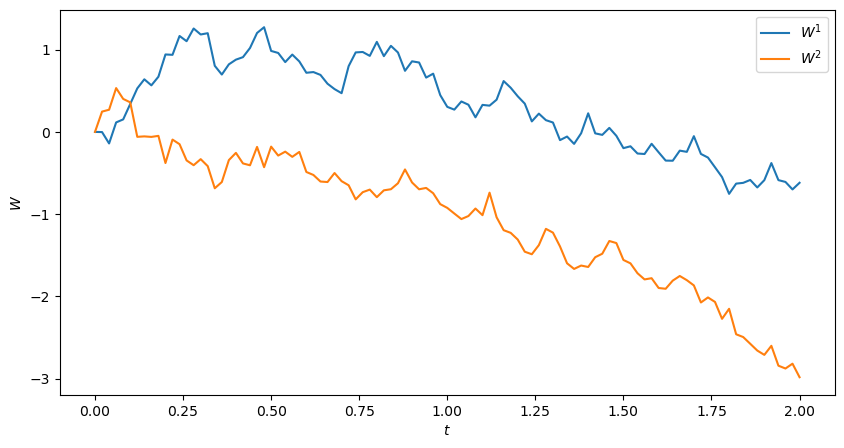

In [ ]:
t_grid = np.linspace(0, T, N+1)

fig, ax  = plt.subplots(figsize=(10,5))
ax.plot(t_grid, W[3,:,0], label=r"$W^1$")
ax.plot(t_grid, W[3,:,1], label=r"$W^2$")
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$W$")

# Compute the expected signature

First we compute the signature using `iisignature`, then we take sample means to estimate the expected signature.

In [ ]:
K = 6 # degree of the signature
sig_W = 
E_sig_W =  # estimated mean
sd_sig_W =  # estimated standard deviation

Just print the results together with the standard MC error estimate.

In [ ]:
for i in range(len(E_sig_W)):
    print(f"E[sig] = {E_sig_W[i]} +- {3*sd_sig_W[i]/np.sqrt(M)}.")


E[sig] = -0.013431349403881111 +- 0.041892889851595456.
E[sig] = -0.01464448725204056 +- 0.042093796768268466.
E[sig] = 0.9750981006389086 +- 0.04102337480977952.
E[sig] = 0.013420425440158172 +- 0.04220369687716758.
E[sig] = 0.016687738451270962 +- 0.042294486279722904.
E[sig] = 0.9844893007080431 +- 0.04155898125160446.
E[sig] = -0.015140717770584258 +- 0.05156539499345383.
E[sig] = -0.012317184070844775 +- 0.042166537808076124.
E[sig] = -0.003826130604355078 +- 0.03348896576668353.
E[sig] = -0.0036366298445539703 +- 0.04150367110461581.
E[sig] = -0.008147925919390148 +- 0.042155979001138016.
E[sig] = -0.0233719370600863 +- 0.034213343313143095.
E[sig] = -0.015546902716108217 +- 0.04253003929992322.
E[sig] = -0.022488721517802603 +- 0.053062534321727736.
E[sig] = 0.4701207326048695 +- 0.04395445534804913.
E[sig] = 0.013511353929046092 +- 0.03841875307376665.
E[sig] = -0.0027379783547743096 +- 0.02929983984916494.
E[sig] = 0.48835234886976386 +- 0.03399169714905443.
E[sig] = 0.0049841

# Code implementing Fawcett's formula

We start with helper code to map indices to multi-indices and conversely. This allows us to properly read the output of `iisignature`.

In [ ]:
class Index2Multi:
    # generate all multi-indices in {0, ..., d} up to length n
    @staticmethod
    def _generate_lists_of_length_n_lexicographic(n, d):
        if n == 0:
            return [[]]

        def generate_lexicographic_lists(length, current_list, d):
            if length == 0:
                return [current_list]
            
            lists = []
            for entry in range(1, d+1):  # 0, 1, ..., d
                new_list = current_list + [entry]
                lists.extend(generate_lexicographic_lists(length - 1, new_list, d))
            return lists

        result = generate_lexicographic_lists(n, [], d)
        return result

    @staticmethod
    def _generate_lists_up_to_n_lexicographic(n, d):
        result = []
        for i in range(n+1):
            result += \
                Index2Multi._generate_lists_of_length_n_lexicographic(i, d)
        return result

    # Create a map between A and B and its inverse.
    # Assume that entries of A are hashable but entries of B are lists.
    @staticmethod
    def _create_bidirectional_mapping(A, B):
        # Convert list entries to tuples to make them hashable
        B_hashable = [tuple(b) for b in B]

        mapping_A_to_B = {a: b for a, b in zip(A, B_hashable)}
        mapping_B_to_A = {b: a for a, b in zip(A, B_hashable)}

        def lookup_A_to_B(item):
            return list(mapping_A_to_B.get(item))

        def lookup_B_to_A(item):
            item_tuple = tuple(item)
            return mapping_B_to_A.get(item_tuple)

        return lookup_A_to_B, lookup_B_to_A

    # Now apply this to create maps between indices and multiindices 
    # and conversely.
    @staticmethod
    def _construct_multi_indices(n, d):
        multi_indices = \
            Index2Multi._generate_lists_up_to_n_lexicographic(n, d)
        N = len(multi_indices)
        indices = list(range(N))
        index2multi, multi2index = \
            Index2Multi._create_bidirectional_mapping(indices, multi_indices)
        
        return indices, multi_indices, index2multi, multi2index
    
    # Finally, we initailize the class
    def __init__(self, K: int, d: int):
        self.K = K
        self.d = d
        self.indices, self.multi_indices, self.index2multi, self.multi2index = Index2Multi._construct_multi_indices(K, d)

    # The call method will call index2multi
    def __call__(self, i: int) -> list:
        return self.index2multi(i)

In [ ]:
index2multi = Index2Multi(K, d)
print(index2multi.indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]


Next, we write code to evaluate $\langle w, \mathbb{E}\left[ \mathbb{W}^{<\infty}_{0,T} \right] \rangle$ for words (i.e., multi-indices) $w$.

In [ ]:
def check_decomposability(x: list) -> int:
    """
    Checks if a list is composed entirely of adjacent identical pairs.

    The function returns 1 if the list is non-empty, has an even length,
    and every adjacent pair of elements (x[i], x[i+1]) consists of identical values.
    Otherwise, it returns 0.

    Args:
        x: A list of numbers (letters).

    Returns:
        1 if the list consists entirely of adjacent identical pairs, 0 otherwise.
    """
    # An empty list does consist of adjacent identical pairs.
    if not x:
        return 1

    # If the list has an odd number of elements, it cannot be
    # composed entirely of pairs.
    if len(x) % 2 != 0:
        return 0

    # Iterate through the list, taking two elements at a time
    # We use a step of 2 (range(0, len(x), 2)) to check adjacent pairs.
    for i in range(0, len(x), 2):
        # If any adjacent pair is not identical, the condition is not met.
        if x[i] != x[i+1]:
            return 0
    
    # If the loop completes, it means all adjacent pairs were identical.
    return 1

def evaluate_Fawcett(d: int, T: float, w: list) -> float:
    """Evalujate the Fawcett formula.

    Parameters
    ----------
    d : int
        Dimension of the Brownian motion
    T : float
        Terminal time.
    w : list
        Word, whose coefficient we want to compute.

    Returns
    -------
    float
        The coefficient of the word w in the expected signature of Brownian motion.
    """
    if not check_decomposability(w):
        return 0
    
    if w == []:
        return 1
    
    k = len(w) // 2
    return (T / 2)**k / math.factorial(k)

# Comparison

Compare the results of the Monte Carlo simulation with the results form the explicit formula. Note that `iisignature` does not return the trivial initial coefficient of the signature.

In [ ]:
i = -1
w = index2multi(i+1)
print(f"Word: {w}, E[sig] = NA +- NA, Fawcett gives {evaluate_Fawcett(d, T, w)}.")
for i in range(len(E_sig_W)):
    w = index2multi(i+1)
    print(f"Word: {w}, error = {E_sig_W[i] - evaluate_Fawcett(d, T, w)} +- {3*sd_sig_W[i]/np.sqrt(M)}.")

Word: [], E[sig] = NA +- NA, Fawcett gives 1.
Word: [1], error = -0.013431349403881111 +- 0.041892889851595456.
Word: [2], error = -0.01464448725204056 +- 0.042093796768268466.
Word: [1, 1], error = -0.02490189936109144 +- 0.04102337480977952.
Word: [1, 2], error = 0.013420425440158172 +- 0.04220369687716758.
Word: [2, 1], error = 0.016687738451270962 +- 0.042294486279722904.
Word: [2, 2], error = -0.01551069929195692 +- 0.04155898125160446.
Word: [1, 1, 1], error = -0.015140717770584258 +- 0.05156539499345383.
Word: [1, 1, 2], error = -0.012317184070844775 +- 0.042166537808076124.
Word: [1, 2, 1], error = -0.003826130604355078 +- 0.03348896576668353.
Word: [1, 2, 2], error = -0.0036366298445539703 +- 0.04150367110461581.
Word: [2, 1, 1], error = -0.008147925919390148 +- 0.042155979001138016.
Word: [2, 1, 2], error = -0.0233719370600863 +- 0.034213343313143095.
Word: [2, 2, 1], error = -0.015546902716108217 +- 0.04253003929992322.
Word: [2, 2, 2], error = -0.022488721517802603 +- 0.053